In [25]:
# Advanced GAN Notebook
# Generative A.I course by Javier Ideami
# https://medium.com/@ideami

# You can explore convolutional layers in depth with this article that I wrote on medium: 
# https://towardsdatascience.com/convolutional-layer-hacking-with-python-and-numpy-e5f64812ca0c

# importing the libraries
import torch, torchvision, os, PIL, pdb
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image, ExifTags
import colorsys
import random
import pylab
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.optim as optim
from tqdm.notebook import tqdm
import os
import random
from IPython import display

def show(tensor, num=25, wandbactive=0, name=''):
    data = tensor.detach().cpu()
    grid = make_grid(data[:num], nrow=5).permute(1,2,0)

    ## optional
    #if (wandbactive==1):
    #wandb.log({name:wandb.Image(grid.numpy().clip(0,1))})

    plt.imshow(grid.clip(0,1))
    plt.show()
    plt.axis('off')
### hyperparameters and general parameters
n_epochs=45
batch_size=128
lr=1e-4
z_dim=200
device='cuda' #GPU

cur_step=0
crit_cycles=5
gen_losses=[]
crit_losses=[]
show_step=35
save_step=35

wandbact=1 # yes, we want to track stats through weights and biases, optional


In [26]:
#### optional
#!pip install wandb -qqq
#import wandb
#wandb.login(key='PUT HERE YOUR WANDB KEY')  #instructions are in the related video :)

In [27]:
#%%capture
#experiment_name = wandb.util.generate_id()

#myrun=wandb.init(
#    project="wgan",
#    group=experiment_name,
#    config={
#        "optimizer":"adam",
#        "model":"wgan gp",
#        "epoch":"1000",
#        "batch_size":128
#    }
#)

#config=wandb.config

## Sometimes this call to the wandb service may fail or give problems.
## If needed, you can use the Runtime->Restart Runtime option in the menus
## to restart and try again. If you keep having issues, you may set wandbact=0
## to skip temporarily the remote stats. You would also
## need to set wandbactive to 0 within the training loop in
## show(fake, wandbactive=0, name='fake') and show(real, wandbactive=0, name='real').
## However, in general this should work with no problems (try a few times if you have issues)

In [28]:
# generator model
# https://medium.com/@ideami

class Generator(nn.Module):
  def __init__(self, z_dim=64, d_dim=16):
    super(Generator, self).__init__()
    self.z_dim=z_dim

    self.gen = nn.Sequential(
            ## ConvTranspose2d: in_channels, out_channels, kernel_size, stride=1, padding=0
            ## Calculating new width and height: (n-1)*stride -2*padding +ks
            ## n = width or height
            ## ks = kernel size
            ## we begin with a 1x1 image with z_dim number of channels (200)
            nn.ConvTranspose2d(z_dim, d_dim * 32, 4, 1, 0), ## 4x4 (ch: 200, 512)
            nn.BatchNorm2d(d_dim*32),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*32, d_dim*16, 4, 2, 1), ## 8x8 (ch: 512, 256)
            nn.BatchNorm2d(d_dim*16),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*16, d_dim*8, 4, 2, 1), ## 16x16 (ch: 256, 128)
            #(n-1)*stride -2*padding +ks = (8-1)*2-2*1+4=16
            nn.BatchNorm2d(d_dim*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*8, d_dim*4, 4, 2, 1), ## 32x32 (ch: 128, 64)
            nn.BatchNorm2d(d_dim*4),
            nn.ReLU(True),            

            nn.ConvTranspose2d(d_dim*4, d_dim*2, 4, 2, 1), ## 64x64 (ch: 64, 32)
            nn.BatchNorm2d(d_dim*2),
            nn.ReLU(True),            

            nn.ConvTranspose2d(d_dim*2, 3, 4, 2, 1), ## 128x128 (ch: 32, 3)
            nn.Tanh() ### produce result in the range from -1 to 1
    )


  def forward(self, noise):
    x=noise.view(len(noise), self.z_dim, 1, 1)  # 128 x 200 x 1 x 1
    return self.gen(x)


def gen_noise(num, z_dim, device='cuda'):
   return torch.randn(num, z_dim, device=device) # 128 x 200



In [29]:
## critic model

class Critic(nn.Module):
  def __init__(self, d_dim=16):
    super(Critic, self).__init__()

    self.crit = nn.Sequential(
      # Conv2d: in_channels, out_channels, kernel_size, stride=1, padding=0
      ## New width and height: # (n+2*pad-ks)//stride +1
      nn.Conv2d(3, d_dim, 4, 2, 1), #(n+2*pad-ks)//stride +1 = (128+2*1-4)//2+1=64x64 (ch: 3,16)
      nn.InstanceNorm2d(d_dim), 
      nn.LeakyReLU(0.2),

      nn.Conv2d(d_dim, d_dim*2, 4, 2, 1), ## 32x32 (ch: 16, 32)
      nn.InstanceNorm2d(d_dim*2), 
      nn.LeakyReLU(0.2),

      nn.Conv2d(d_dim*2, d_dim*4, 4, 2, 1), ## 16x16 (ch: 32, 64)
      nn.InstanceNorm2d(d_dim*4), 
      nn.LeakyReLU(0.2),
              
      nn.Conv2d(d_dim*4, d_dim*8, 4, 2, 1), ## 8x8 (ch: 64, 128)
      nn.InstanceNorm2d(d_dim*8), 
      nn.LeakyReLU(0.2),

      nn.Conv2d(d_dim*8, d_dim*16, 4, 2, 1), ## 4x4 (ch: 128, 256)
      nn.InstanceNorm2d(d_dim*16), 
      nn.LeakyReLU(0.2),

      nn.Conv2d(d_dim*16, 1, 4, 1, 0), #(n+2*pad-ks)//stride +1=(4+2*0-4)//1+1= 1X1 (ch: 256,1)

    )


  def forward(self, image):
    # image: 128 x 3 x 128 x 128
    crit_pred = self.crit(image) # 128 x 1 x 1 x 1
    return crit_pred.view(len(crit_pred),-1) ## 128 x 1  
  

In [30]:
## optional, init your weights in different ways
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
      torch.nn.init.normal_(m.weight, 0.0, 0.02)
      torch.nn.init.constant_(m.bias,0)

    if isinstance(m,nn.BatchNorm2d):
      torch.nn.init.normal_(m.weight, 0.0, 0.02)
      torch.nn.init.constant_(m.bias,0)


##gen=gen.apply(init_weights)
##crit=crit.apply(init_weights)




['test/602.png', 'test/667.png', 'test/676.png', 'test/717.png', 'test/619.png']


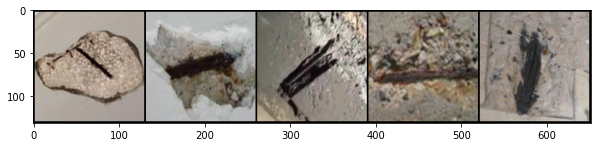

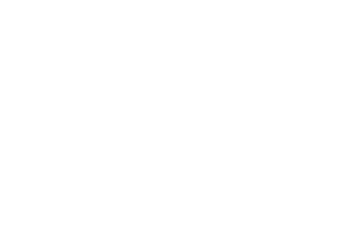

In [34]:
### Dataset, DataLoader, declare gen,crit, test dataset

class image_loader(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path=''):
        'Initialization'
        self.transform = transform
        self.image_paths = glob.glob(data_path+'/*.png')
        self.labels_dict = {"Healthy":0, "Corrosion":1,
                            "Cracks":2, "Spalling":3}
        self.inv_labels_dict = {v: k for k, v in self.labels_dict.items()}
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        
        X = self.transform(image)
        y = self.labels_dict[image_path.split("/")[-2]]
        
        return X, y

IMAGE_SIZE = 128
BATCH_SIZE = 32
train_transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), 
                                    transforms.ToTensor()])

trainset = image_loader(train=True, transform=train_transform, data_path='FewShotData2/Spalling')
dataloader = DataLoader(trainset, shuffle=True, batch_size=BATCH_SIZE, num_workers=12)

## Models
gen = Generator(z_dim).to(device)
crit = Critic().to(device)

## Optimizers
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5,0.9))
crit_opt= torch.optim.Adam(crit.parameters(), lr=lr, betas=(0.5,0.9))

## Initializations
##gen=gen.apply(init_weights)
##crit=crit.apply(init_weights)

#wandb optional
#if (wandbact==1):
#  wandb.watch(gen, log_freq=100)
#  wandb.watch(crit, log_freq=100)

plt.figure(figsize=(10,10))
x,y=next(iter(dataloader))
show(x, num=5)


In [ ]:
## gradient penalty calculation

def get_gp(real, fake, crit, alpha, gamma=10):
    mix_images = real * alpha + fake * (1-alpha) # 128 x 3 x 128 x 128
    mix_scores = crit(mix_images) # 128 x 1

    gradient = torch.autograd.grad(
      inputs = mix_images,
      outputs = mix_scores,
      grad_outputs=torch.ones_like(mix_scores),
      retain_graph=True,
      create_graph=True,
    )[0] # 128 x 3 x 128 x 128

    gradient = gradient.view(len(gradient), -1)   # 128 x 49152
    gradient_norm = gradient.norm(2, dim=1) 
    gp = gamma * ((gradient_norm-1)**2).mean()

    return gp



In [ ]:
## Save and load checkpoints

root_path='./data/'

def save_checkpoint(name):
    torch.save({
      'epoch': epoch,
      'model_state_dict': gen.state_dict(),
      'optimizer_state_dict': gen_opt.state_dict()      
    }, f"{root_path}G-{name}.pkl")

    torch.save({
      'epoch': epoch,
      'model_state_dict': crit.state_dict(),
      'optimizer_state_dict': crit_opt.state_dict()      
    }, f"{root_path}C-{name}.pkl")
  
    print("Saved checkpoint")

def load_checkpoint(name):
    checkpoint = torch.load(f"{root_path}G-{name}.pkl")
    gen.load_state_dict(checkpoint['model_state_dict'])
    gen_opt.load_state_dict(checkpoint['optimizer_state_dict'])

    checkpoint = torch.load(f"{root_path}C-{name}.pkl")
    crit.load_state_dict(checkpoint['model_state_dict'])
    crit_opt.load_state_dict(checkpoint['optimizer_state_dict'])

    print("Loaded checkpoint")

#load_checkpoint('final-wgan-noinit')

In [ ]:
#!cp C-final* ./data/
#!cp G-final* ./data/
#epoch=1
#save_checkpoint("test")
#load_checkpoint("test")


In [ ]:
## Training loop 

for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_bs= len(real) #128
        real=real.to(device)

        ### CRITIC
        mean_crit_loss = 0
        for _ in range(crit_cycles):
            crit_opt.zero_grad()

            noise=gen_noise(cur_bs, z_dim)
            fake = gen(noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            alpha=torch.rand(len(real),1,1,1,device=device, requires_grad=True) # 128 x 1 x 1 x 1
            gp = get_gp(real, fake.detach(), crit, alpha)

            crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() + gp

            mean_crit_loss+=crit_loss.item() / crit_cycles

            crit_loss.backward(retain_graph=True)
            crit_opt.step()

        crit_losses+=[mean_crit_loss]

        ### GENERATOR
        gen_opt.zero_grad()
        noise = gen_noise(cur_bs, z_dim)
        fake = gen(noise)
        crit_fake_pred = crit(fake)

        gen_loss = -crit_fake_pred.mean()
        gen_loss.backward()
        gen_opt.step()

        gen_losses+=[gen_loss.item()]

        ### Stats  

        #if (wandbact==1):
        #    wandb.log({'Epoch': epoch, 'Step': cur_step, 'Critic loss':mean_crit_loss, 'Gen loss': gen_loss})

        if cur_step % save_step == 0 and cur_step > 0:
            print("Saving checkpoint: ", cur_step, save_step)
            save_checkpoint("latest")

        if (cur_step % show_step == 0 and cur_step > 0):
            show(fake, wandbactive=1, name='fake')
            show(real, wandbactive=1, name='real')

            gen_mean=sum(gen_losses[-show_step:]) / show_step
            crit_mean = sum(crit_losses[-show_step:]) / show_step
            print(f"Epoch: {epoch}: Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")

            plt.plot(
              range(len(gen_losses)),
              torch.Tensor(gen_losses),
              label="Generator Loss"
            )

            plt.plot(
              range(len(gen_losses)),
              torch.Tensor(crit_losses),
              label="Critic Loss"
            )

            plt.ylim(-150,150)
            plt.legend()
            plt.show()

        cur_step+=1


In [ ]:
# number of steps per epoch
# 10000 / 128 = 78.125
# 50000 / 128 = 390.625

In [ ]:
#### Generate new faces
noise = gen_noise(batch_size, z_dim)
fake = gen(noise)
show(fake)

In [ ]:
plt.imshow(fake[16].detach().cpu().permute(1,2,0).squeeze().clip(0,1))

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

# MORPHING, interpolation between points in latent space
gen_set=[]
z_shape=[1,200,1,1]
rows=4
steps=17

for i in range(rows):
  z1,z2 = torch.randn(z_shape), torch.randn(z_shape)
  for alpha in np.linspace(0,1,steps):
    z=alpha*z1 + (1-alpha)*z2
    res=gen(z.cuda())[0]
    gen_set.append(res)

fig = plt.figure(figsize=(25,11))
grid=ImageGrid(fig, 111, nrows_ncols=(rows,steps), axes_pad=0.1)

for ax , img in zip (grid, gen_set):
  ax.axis('off')
  res=img.cpu().detach().permute(1,2,0)
  res=res-res.min()
  res=res/(res.max()-res.min())
  ax.imshow(res.clip(0,1.0))

plt.show()